In [1]:
from lol_data import get_summoner_lol_data, get_match_ids, get_match_data, calculate_win_percentage_per_role
from lol_visuals import visualize_win_percentages, plot_win_percentage_over_time, visualize_champion_stats
from config import API_KEY

summoner_name = input("Enter Summoner Name: ")
region = input("Enter Region (e.g., na1, euw1): ")
queue_type = input("Enter Queue Type (e.g., ranked_solo_duo): ")

# ... (bestaande code blijft hetzelfde)
summoner_data = get_summoner_lol_data(API_KEY, summoner_name, region)
match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type, count=50)
if summoner_data:
    print(f"Summoner name: {summoner_data['name']}")
    print(f"Summoner Level: {summoner_data['summonerLevel']}")
    print(f"Below is the data analyses for {summoner_name} in {queue_type}:")
    match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type)
    if match_ids:
        matches = []
        for match_id in match_ids:
            match_data = get_match_data(API_KEY, match_id, region)
            if match_data:
                matches.append(match_data)
            else:
                print(f"Error fetching match data for match ID {match_id}")


Summoner name: Kiirbb
Summoner Level: 265
Below is the data analyses for kiirbb in ranked_solo_Duo:


Champion Name: Teemo, Champion ID: 17
Champion Name: Rammus, Champion ID: 33
Champion Name: Xerath, Champion ID: 101
Champion Name: Vayne, Champion ID: 67
Champion Name: Pyke, Champion ID: 555
Champion Name: Morgana, Champion ID: 25
Champion Name: Kayn, Champion ID: 141
Champion Name: Viktor, Champion ID: 112
Champion Name: Aphelios, Champion ID: 523
Champion Name: Zyra, Champion ID: 143
Champion Name: Teemo, Champion ID: 17
Champion Name: Evelynn, Champion ID: 28
Champion Name: Zed, Champion ID: 238
Champion Name: Tristana, Champion ID: 18
Champion Name: Leona, Champion ID: 89
Champion Name: Trundle, Champion ID: 48
Champion Name: MasterYi, Champion ID: 11
Champion Name: Xerath, Champion ID: 101
Champion Name: MissFortune, Champion ID: 21
Champion Name: Yuumi, Champion ID: 350
Champion Name: Olaf, Champion ID: 2
Champion Name: Kayn, Champion ID: 141
Champion Name: Yasuo, Champion ID: 157
Champion Name: Caitlyn, Champion ID: 51
Champion Name: MissFortune, Champion ID: 21
Champion Name:

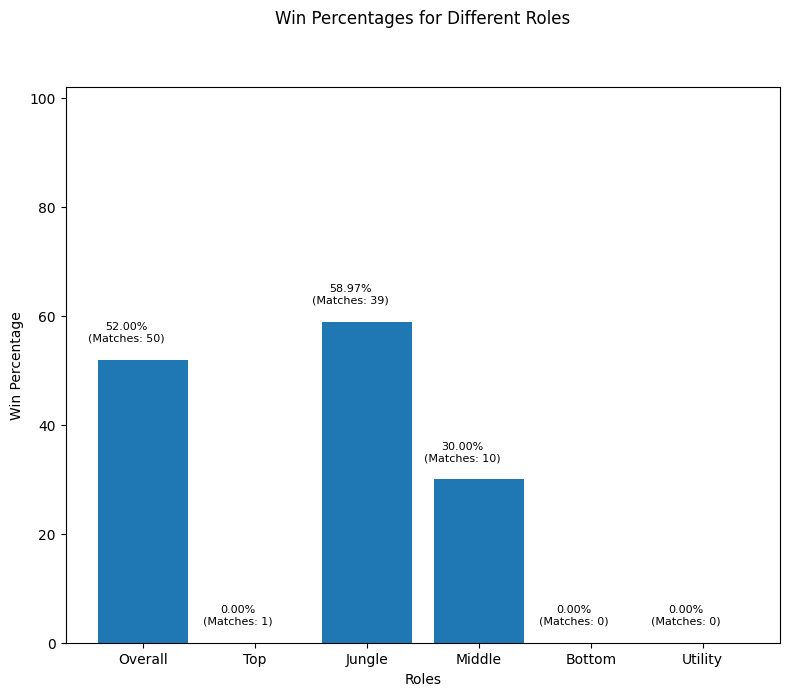

In [2]:
win_percentages = calculate_win_percentage_per_role(matches, summoner_data['puuid'])
visualize_win_percentages(win_percentages)


Total games in the last two weeks for this queue type: 21


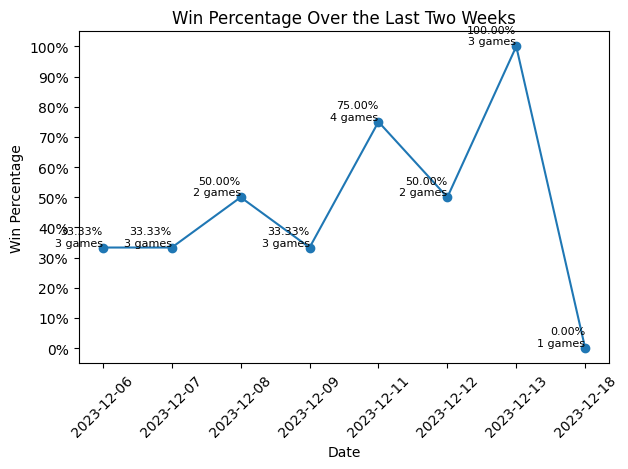

In [3]:
plot_win_percentage_over_time(matches, summoner_data)


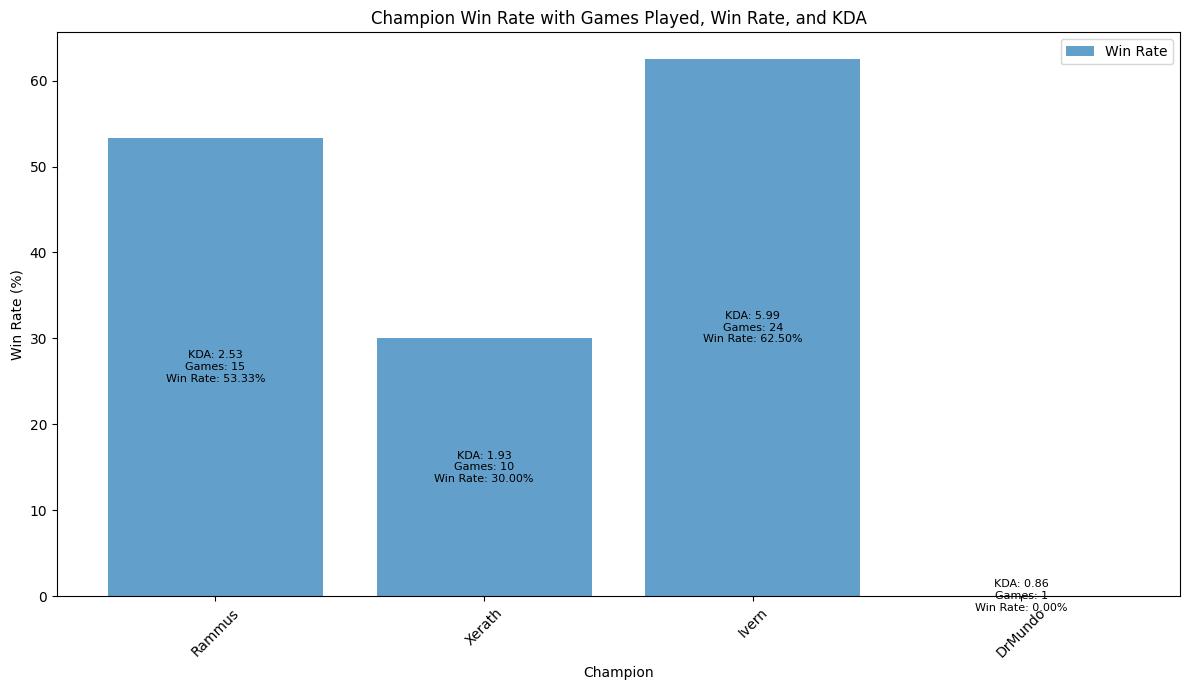

In [4]:
visualize_champion_stats(matches, summoner_data)
